In [6]:
# Main code written by Morten Hjorth-Jensen
# Modified by Joseph P.Vera and Luis Jimenez

# Common imports
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "Results/VMCHarmonic"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

outfile = open(data_path("VMCHarmonic.dat"),'w')

In [7]:
%matplotlib inline

# With importance sampling 
from math import exp, sqrt
from random import random, seed, normalvariate
import numpy as np
import matplotlib.pyplot as plt
from decimal import *

# Trial wave function for the Harmonic oscillator in generalized form (Generalized equation)
#betha = 1
def WaveFunction(r,alpha):
    sum = 0
    for i in range(N):
#        sum = 0
        for j in range(D):
            sum += r[i,j]*r[i,j]
    return exp(-alpha*sum)

# Local energy  for the Harmonic oscillator in generalized form (Generalized equation)
def LocalEnergy(r,alpha):
    sum1 = 0
    for i in range(N):
        for j in range(D):
            sum1 += r[i,j]*r[i,j] 
    return (0.5 - 2*alpha*alpha)*sum1 + N*D*alpha
    
# Drift force (Generalized equation)
def QuantumForce(r,alpha):
    qforce = np.zeros((N,D), np.double)
    sum2 = 0
    for i in range(N):
        for j in range(D):
            sum2 += r[i,j] 
    qforce[i,:] = -4*alpha*sum2
    return qforce

In [8]:
# The Monte Carlo sampling with the Metropolis algorithm
# The argument types will be inferred by Numba when the function is called.
def MonteCarloSampling():

    NumberMCcycles= 1000000  # 7 zeros
    Dif = 0.5
    StepSize = 1.0
    # positions
    PositionOld = np.zeros((N,D), np.double)
    PositionNew = np.zeros((N,D), np.double)
    # Quantum force
    QuantumForceOld = np.zeros((N,D), np.double)
    QuantumForceNew = np.zeros((N,D), np.double)

    # seed for random number generator
    seed()
    # start variational parameter
    alpha = 0.1
    for ia in range(MaxVariations):
        alpha += .05
        AlphaValues[ia] = alpha
        energy = energy2 = 0.0       # Initial conditions
        DeltaE = 0.0                 # Initial conditions
        # Initial position
        for i in range(N):
            for j in range(D):
                PositionOld[i,j] = normalvariate(0.0,1.0)*sqrt(StepSize)
        wfold = WaveFunction(PositionOld,alpha)
        QuantumForceOld = QuantumForce(PositionOld,alpha)
        
        # Loop over MC MCcycles
        for MCcycle in range(NumberMCcycles):
            # Trial position 
            for i in range(N):
                for j in range(D):
                    PositionNew[i,j] = PositionOld[i,j] + normalvariate(0.0,1.0)*sqrt(StepSize) + QuantumForceOld[i,j]*StepSize*Dif
                wfnew = WaveFunction(PositionNew,alpha)
                QuantumForceNew = QuantumForce(PositionNew,alpha)
                GreensFunction = 0.0
                for j in range(D):
                    GreensFunction += 0.5*(QuantumForceOld[i,j]+QuantumForceNew[i,j])*(Dif*StepSize*0.5*(QuantumForceOld[i,j]-QuantumForceNew[i,j])- PositionNew[i,j]+PositionOld[i,j])
                GreensFunction = exp(GreensFunction)
                ProbabilityRatio = GreensFunction*wfnew**2/wfold**2
                # Metropolis-Hastings (Markov Chain) test to see whether we accept the move
                if random() <= ProbabilityRatio:
                   for j in range(D):
                       PositionOld[i,j] = PositionNew[i,j]
                       QuantumForceOld[i,j] = QuantumForceNew[i,j]
                   wfold = wfnew
            DeltaE = LocalEnergy(PositionOld,alpha)
            energy += DeltaE
            energy2 += DeltaE**2
        #We calculate mean, variance and error
        energy /= NumberMCcycles
        energy2 /= NumberMCcycles
        variance = energy2 - energy**2
        error = sqrt(variance/NumberMCcycles)
        Energies[ia] = energy    
        Variances[ia] = variance    
        outfile.write('%f %f %f %f \n' %(alpha,energy,variance,error))  # Save the information
    return Energies, AlphaValues, Variances

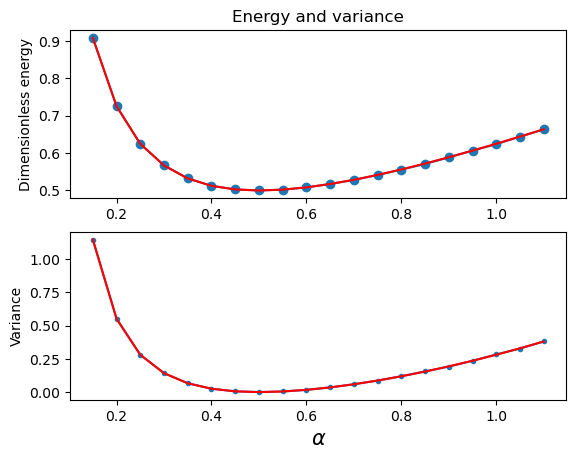

    Alpha    Energy  Exact Energy  Variance  Exact Variance
0    0.15  0.907236      0.908333  1.146788        1.150139
1    0.20  0.725795      0.725000  0.553889        0.551250
2    0.25  0.624129      0.625000  0.279939        0.281250
3    0.30  0.567468      0.566667  0.142801        0.142222
4    0.35  0.532327      0.532143  0.066797        0.066352
5    0.40  0.512427      0.512500  0.025308        0.025313
6    0.45  0.502813      0.502778  0.005585        0.005571
7    0.50  0.500000      0.500000  0.000000        0.000000
8    0.55  0.502185      0.502273  0.004576        0.004556
9    0.60  0.508229      0.508333  0.016831        0.016806
10   0.65  0.517537      0.517308  0.035074        0.035214
11   0.70  0.528168      0.528571  0.059150        0.058776
12   0.75  0.541445      0.541667  0.086807        0.086806
13   0.80  0.555883      0.556250  0.119675        0.118828
14   0.85  0.570915      0.572059  0.155706        0.154503
15   0.90  0.588488      0.588889  0.192

In [9]:
import time
inicio = time.time()
#############################################################################################################################################
# Values for N and D can be changed. N take values {1,2,3,...,500,...} and D is given by {1,2,3}
N=1  #Number of particles
D=1  #Dimension
MaxVariations = 20
Energies = np.zeros((MaxVariations))
ExactEnergies = np.zeros((MaxVariations))
ExactVariance = np.zeros((MaxVariations))
Variances = np.zeros((MaxVariations))
AlphaValues = np.zeros(MaxVariations)
(Energies, AlphaValues, Variances) = MonteCarloSampling()
outfile.close()
ExactEnergies = (0.5 - 2*AlphaValues*AlphaValues)*((D*N)/(4*AlphaValues)) + D*N*AlphaValues        # Generalized energy equation
ExactVariance = 0.0625*N*D*((D+2)/(AlphaValues*AlphaValues))*(0.5 - 2*AlphaValues*AlphaValues)**2 + 0.5*N*(0.5 - 2*AlphaValues*AlphaValues)*D**2 + N*(D*AlphaValues)**2  - (1/N)*ExactEnergies*ExactEnergies   # Generalization Variance equation  

# Plot
plt.subplot(2, 1, 1)
plt.plot(AlphaValues, Energies, 'o-',AlphaValues, ExactEnergies,'r-')
plt.title('Energy and variance')
plt.ylabel('Dimensionless energy')
plt.subplot(2, 1, 2)
plt.plot(AlphaValues, Variances, '.-',AlphaValues, ExactVariance,'r-')
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel('Variance')
save_fig("VMCHarmonic")
plt.show()

# Using Pandas
import pandas as pd
from pandas import DataFrame
data ={'Alpha':AlphaValues, 'Energy':Energies,'Exact Energy':ExactEnergies,'Variance':Variances,'Exact Variance':ExactVariance,}
frame = pd.DataFrame(data)
print(frame)
#############################################################################################################################################
fin = time.time()
print("---------------------------------------------------------------")
print("---------------------------------------------------------------")
print("CPU time =",fin-inicio, "seconds")
print("---------------------------------------------------------------")
print("---------------------------------------------------------------")